In [2]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [3]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

freeman['norm_resp'] = dict()
freeman['norm_resp']['2Hz'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4Hz'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8Hz'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16Hz'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

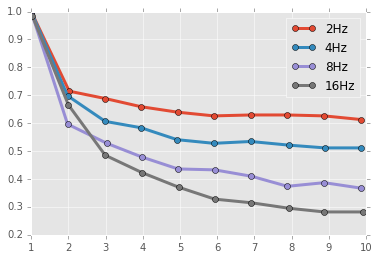

In [13]:
for cond in ['2Hz', '4Hz', '8Hz', '16Hz']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond)
plt.legend()

# Functions
-----------------

Following are all utily funcions used in this script.

In [3]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample, tau_inl=18.0 / 1000, delay_inl=40.0 / 1000,
                 lweight=0.636):
        super(GanglionCellResponse, self).__init__(tsample, tau_inl=tau_inl,
                                                   delay_inl=delay_inl,
                                                   lweight=lweight)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [4]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [5]:
# Monophasic pulse train
def get_pulse_train(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 20.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

In [6]:
def run_jensen_data(pulse_durs, currents, ptype, implant, retina, verbose=False):
    tsample = 0.005 / 1000
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    amp_in = [0.1, 1, 10]
    
    delay_inl = 40.0 / 1000
    
    tau_inl = 1.0 / 1000
    lweight = 0.636
    ecs_scale = 0.1
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                              tau_inl=tau_inl, lweight=lweight)
    
    act_out = []
    for pd, amp in zip(pulse_durs, currents):
        if verbose:
            print('- Processing pulse dur %f - current %f' % (pd, amp))
        stim = get_pulse_train(ptype, stim_freq, amp, pd, stim_dur, tsample)
        idx_onset = stim.data.nonzero()[0][0]
        mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                                 ecs_scale=ecs_scale, engine='joblib', rsample=1,
                                 verbose=False)
        act_out.append(mov.data.max())
        
    return act_out

In [7]:
def run_fig4(pulse_durs, ptype, implant, retina, amp_th, verbose=False):
    tsample = 0.005 / 1000
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    amp_in = [0.1, 1, 10]
    
    delay_inl = 40.0 / 1000
    
    tau_inl = 1.0 / 1000
    lweight = 0.636
    ecs_scale = 0.1
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                              tau_inl=tau_inl, lweight=lweight)
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_pulse_train(ptype, stim_freq, amp_th, pulse_durs[0], stim_dur, tsample)
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False, engine='joblib',
                             ecs_scale=ecs_scale, rsample=1, verbose=False)
    act_match = mov.data.max()

    if verbose:
        print('- Threshold=%f' %  act_match)

    amp_match = []
    for pd in pulse_durs:
        if verbose:
            print('- Processing pulse dur %f' % pd)
        act_out = []
        for amp in amp_in:
            stim = get_pulse_train(ptype, stim_freq, amp, pd, stim_dur, tsample)
            idx_onset = stim.data.nonzero()[0][0]
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                                     ecs_scale=ecs_scale, engine='joblib', rsample=1,
                                     verbose=False)
            act_out.append(mov.data.max())
        amp_match.append(fit_amps(amp_in, act_out, act_match))
        
    return amp_match

# Run model
-----------------

In [8]:
# Run thresholding experiment: Observe output for all specified threshold currents.
# If our model is accurate, these should all result in the same model output.
threshold = dict()

r_sampling = 100
axon_lambda = 2
verbose = False

for diam in [125.0, 500.0]:
    # Create an implant
    ename = 'E%d' % diam
    implant = e2cm.ElectrodeArray('epiretinal', diam / 2.0, -500, -500, 0, ename)

    # Create a retina
    retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                        xlo=implant[0].x_center, xhi=implant[0].x_center,
                        ylo=implant[0].y_center, yhi=implant[0].y_center)
    
    # Run threshold and store output
    print('Running %s' % ename)
    threshold[ename] = dict()
    threshold[ename]['implant'] = implant
    for ptype in ['cathodic', 'anodic']:
        threshold[ename][ptype] = dict()
        threshold[ename][ptype]['pulsedur'] = jensen[ename][ptype][:, 0]
        threshold[ename][ptype]['currents'] = jensen[ename][ptype][:, 1]
        act = run_jensen_data(threshold[ename][ptype]['pulsedur'], threshold[ename][ptype]['currents'],
                              ptype, implant, retina, verbose)
        threshold[ename][ptype]['out'] = act

Running E125
Running E500


In [9]:
# Run the real experiment: Reproduce Jensen data
model = dict()

r_sampling = 100
axon_lambda = 2
verbose = False

for diam in [125.0, 500.0]:
    # Create an implant
    ename = 'E%d' % diam
    implant = e2cm.ElectrodeArray('epiretinal', diam / 2.0, -500, -500, 0, ename)
    
    # Create a retina
    retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                        xlo=implant[0].x_center, xhi=implant[0].x_center,
                        ylo=implant[0].y_center, yhi=implant[0].y_center)
    
    # Run model and store output
    print('Running %s' % ename)
    model[ename] = dict()
    model[ename]['implant'] = implant
    model[ename]['pulsedur'] = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]) / 1000
    for ptype in ['cathodic', 'anodic']:
        act = run_fig4(model[ename]['pulsedur'], ptype, implant, retina,
                       jensen[ename][ptype][-1, 1], verbose)
        model[ename][ptype] = act

Running E125
Running E500


# Results
---------

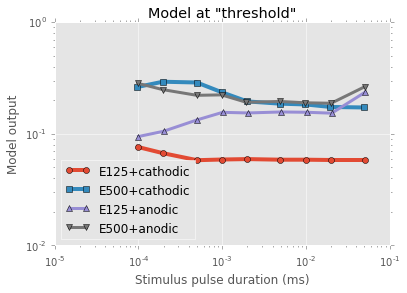

In [10]:
# In a perfect world, these would all be horizontal lines, because no matter the
# set up, the threshold current should give the same output.
plt.loglog(threshold['E125']['cathodic']['pulsedur'], threshold['E125']['cathodic']['out'], 'o-',
         linewidth=4, label='E125+cathodic')
plt.loglog(threshold['E500']['cathodic']['pulsedur'], threshold['E500']['cathodic']['out'], 's-',
         linewidth=4, label='E500+cathodic')
plt.loglog(threshold['E125']['anodic']['pulsedur'], threshold['E125']['anodic']['out'], '^-',
         linewidth=3, label='E125+anodic')
plt.loglog(threshold['E500']['anodic']['pulsedur'], threshold['E500']['anodic']['out'], 'v-',
         linewidth=3, label='E500+anodic')
plt.legend(loc='best')
# plt.ylim(0, 0.5)
# plt.xlim(-0.01, 0.06)
plt.xlabel('Stimulus pulse duration (ms)')
plt.ylabel('Model output')
plt.title('Model at "threshold"')

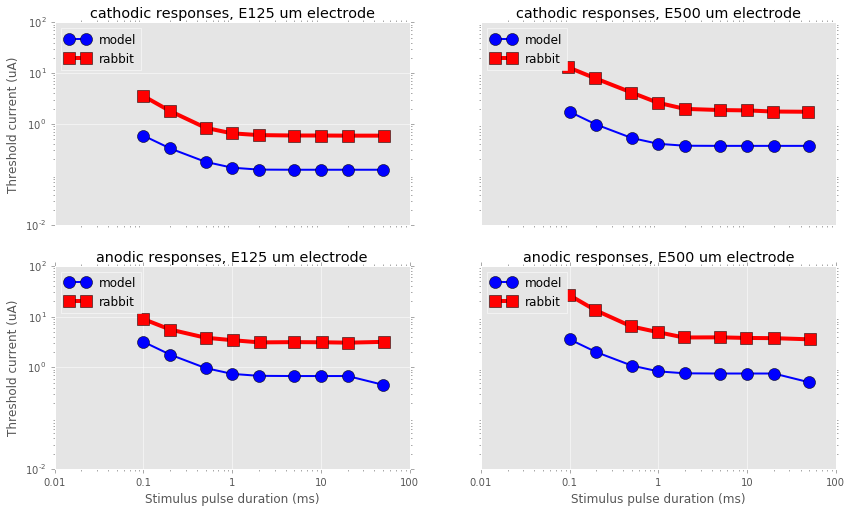

In [11]:
plt.figure(figsize=(14, 8))

subplot = 1
for ptype in ['cathodic', 'anodic']:
    for ename in ['E125', 'E500']:
        plt.subplot(2, 2, subplot)
        if ename in model:
            if ptype in model[ename]:
                plt.loglog(model[ename]['pulsedur'], model[ename][ptype],
                           'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen[ename][ptype][:, 0], jensen[ename][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        plt.title('%s responses, %s um electrode' % (ptype, ename))
        plt.legend(loc='upper left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1